# Data sourcing and preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import hashlib
from datetime import datetime
from google.colab import files

In [2]:
# Load the 'Flights' and 'Sales' tables into DataFrame variables
flights_data = pd.read_csv('Filghts TEC_Valid.csv')

In [3]:
sales_data = pd.read_csv('Sales TEC_Valid.csv')

## Preprocessing of Flights Data


### Asignar un id único según la ruta de vuelo

In [4]:
# Convert date columns to datetime
flights_data['STD'] = pd.to_datetime(flights_data['STD'])
flights_data['STA'] = pd.to_datetime(flights_data['STA'])

# Función para crear un "hash" de la ruta
def get_route_id(row):
    # Check if either STD or STA is NaT
    if pd.isnull(row['STD']) or pd.isnull(row['STA']):
        return None

    # Extract hour and minute components from the datetime objects
    std_hour_minute = row['STD'].strftime('%H:%M')
    sta_hour_minute = row['STA'].strftime('%H:%M')

    # Concatenate the departure station, arrival station, and hour-minute components
    return f"{row['DepartureStation']}_{row['ArrivalStation']}_{std_hour_minute}_{sta_hour_minute}"

# Aplicar la función hash para crear la columna 'Route_Hash'
flights_data['Route_Hash'] = flights_data.apply(get_route_id, axis=1)

# Apply the factorize method to create the 'Route_ID' column
flights_data['Route_ID'] = flights_data['Route_Hash'].factorize()[0]

# Save original copy of flights data
og_flights_data = flights_data.copy()

### Más procesamiento

- imputar datos de passengers que no se encuentren según el promedio de passengers para esa ruta,
- limitar datos a 2023,
- quitar datos poco relevantes

In [5]:
month = 1

In [6]:
#### FOR ALL ENTRIES IN FLIGHTS DATA ####

# Conditionally replace passengers with capacity if passengers exceed capacity
flights_data['Passengers'] = np.where(flights_data['Passengers'] > flights_data['Capacity'], flights_data['Capacity'], flights_data['Passengers'])

# Calculate the flight duration between STD and STA, in minutes
flights_data['Duration'] = (flights_data['STA'] - flights_data['STD']).dt.total_seconds() / 60  # in minutes

# Drop irrelevant columns and datetime columns because we already created specific unique routes and duration
flights_data.drop(columns=['Aeronave', 'Route_Hash', 'STA', 'DepartureStation', 'ArrivalStation'], inplace=True)


#### DIVIDE ENTRIES BY YEAR AND MONTH ####

# Filter data for the year 2023
flights_data_2024 = flights_data[(flights_data['STD'].dt.year == 2024) & (flights_data['STD'].dt.month == month)]
# Filter data for the year 2024
flights_data_2023 = flights_data[(flights_data['STD'].dt.year == 2023) & (flights_data['STD'].dt.month == month)]

# Remove STD column now that it no longer serves a purpose after getting the Route_ID
flights_data_2023 = flights_data_2023.drop(columns=['STD'])
flights_data_2024 = flights_data_2024.drop(columns=['STD'])


#### ONLY FOR 2023 ####

# Fill missing values in 'Passengers' column with median for each route
flights_data_2023['Passengers'] = flights_data_2023.groupby(['Route_ID'])['Passengers'].transform(lambda x: x.fillna(x.median()))
# Fill missing values in 'Bookings' column with mean for each route
flights_data_2023['Bookings'] = flights_data_2023.groupby(['Route_ID'])['Bookings'].transform(lambda x: x.fillna(x.mean()))


#### FOR BOTH 2024 AND 2023 ####

# Remove duplicates for both 2023 and 2024
flights_data_2023 = flights_data_2023.drop_duplicates()
flights_data_2024 = flights_data_2024.drop_duplicates()

In [7]:
flights_data_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8694 entries, 35 to 245666
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Flight_ID         8694 non-null   object 
 1   Destination_Type  8694 non-null   object 
 2   Origin_Type       8694 non-null   object 
 3   Capacity          8694 non-null   int64  
 4   Passengers        8694 non-null   float64
 5   Bookings          8694 non-null   float64
 6   Route_ID          8694 non-null   int64  
 7   Duration          8694 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 611.3+ KB


## Preprocessing of Sales Data

In [8]:
# Usar únicamente productos relevantes (que van en vuelo)
categories_to_keep = ['Botanas', 'Licores', 'Refrescos', 'Galletas', 'Sopas',
                      'Perecederos', 'Bebidas Calientes', 'Lacteos', 'Alimentos Charter']

# Filtrar el DataFrame para mantener solo las categorías deseadas
sales_data = sales_data[sales_data['ProductType'].isin(categories_to_keep)]

In [9]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2108296 entries, 0 to 2564360
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Flight_ID    object 
 1   ProductType  object 
 2   ProductName  object 
 3   Quantity     int64  
 4   TotalSales   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 96.5+ MB


## Después de filtrado, unir tablas para obtener productos a analizar

In [10]:
# Join the tables on the common column 'Flight_ID'
merged_data_2023 = pd.merge(flights_data_2023, sales_data, on='Flight_ID', how='outer')
merged_data_2024 = pd.merge(flights_data_2024, sales_data, on='Flight_ID', how='outer')

merged_data_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2112147 entries, 0 to 2112146
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Flight_ID         object 
 1   Destination_Type  object 
 2   Origin_Type       object 
 3   Capacity          float64
 4   Passengers        float64
 5   Bookings          float64
 6   Route_ID          float64
 7   Duration          float64
 8   ProductType       object 
 9   ProductName       object 
 10  Quantity          float64
 11  TotalSales        float64
dtypes: float64(7), object(5)
memory usage: 193.4+ MB


In [11]:
merged_data_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2118871 entries, 0 to 2118870
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Flight_ID         object 
 1   Destination_Type  object 
 2   Origin_Type       object 
 3   Capacity          float64
 4   Passengers        float64
 5   Bookings          float64
 6   Route_ID          float64
 7   Duration          float64
 8   ProductType       object 
 9   ProductName       object 
 10  Quantity          float64
 11  TotalSales        float64
dtypes: float64(7), object(5)
memory usage: 194.0+ MB


In [12]:
flights_data_2023.sample(5)

,Flight_ID,Destination_Type,Origin_Type,Capacity,Passengers,Bookings,Route_ID,Duration
135183,8c7f89f074b8eb7da61d44504dbccbcb,Ecoturismo,Ciudad Principal,240,240.0,167.0,1561,110.0
173907,b4f4d6e1d613c47c351bb3359cf24346,Ciudad Principal,Ciudad Principal,180,112.0,73.0,1002,95.0
215270,e01a1ab1ac5a49e97e7ac1655223df80,Ciudad Fronteriza,Ciudad Principal,186,186.0,120.0,617,70.0
41042,2aad3f0ac8575d66381956c982ba75d6,Ciudad Principal,MX Amigos y Familia,220,177.0,136.0,1445,215.0
7730,0804580236aed4fe4faa4fea5b6031cb,Ciudad Fronteriza,Ciudad Principal,186,186.0,124.0,395,105.0


# Data visualization

## Total sales from random flight routes

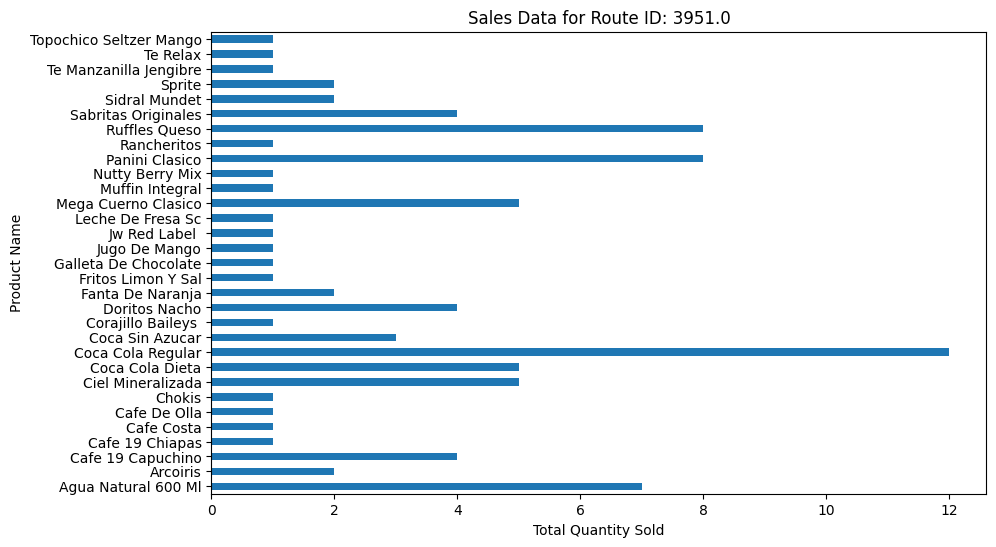

In [13]:
# Select a random route ID
random_route_id = np.random.choice(merged_data_2023['Route_ID'].unique())

# Filter the DataFrame for the selected Route ID
random_route_data = merged_data_2023[merged_data_2023['Route_ID'] == random_route_id]

# Create a simple horizontal visualization of the grouped data
plt.figure(figsize=(10, 6))
random_route_data.groupby('ProductName')['Quantity'].sum().plot(kind='barh')
plt.title(f'Sales Data for Route ID: {random_route_id}')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Name')
plt.show()

## In how many flights Y are X quantity of products sold?

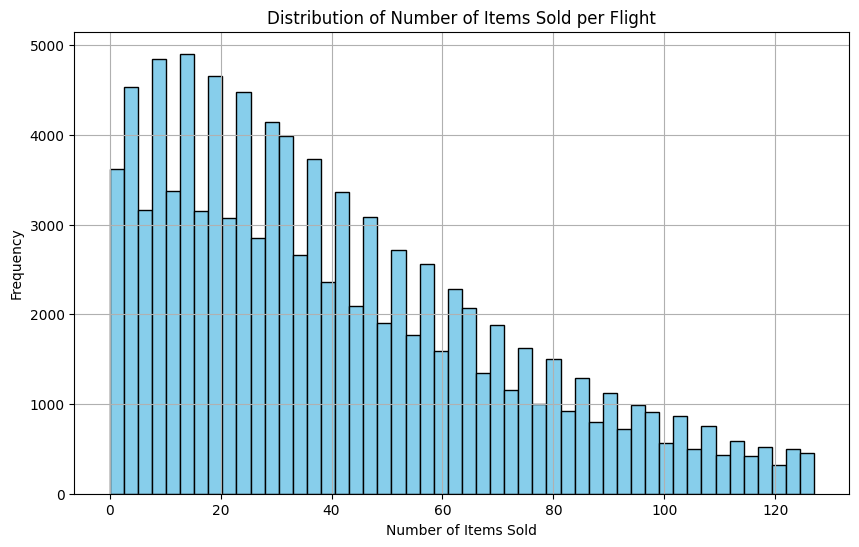

In [14]:
# Group the data by Flight ID and calculate the total number of items sold per flight
items_sold_per_flight = merged_data_2023.groupby('Flight_ID')['Quantity'].sum()

# Define the range for the x-axis (remove outliers)
x_range = (0, items_sold_per_flight.quantile(0.95))

# Plot the distribution of number of items sold per flight
plt.figure(figsize=(10, 6))
plt.hist(items_sold_per_flight, bins=50, range=x_range, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Items Sold per Flight')
plt.xlabel('Number of Items Sold')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## How much of each type of product is sold (sales frequency)

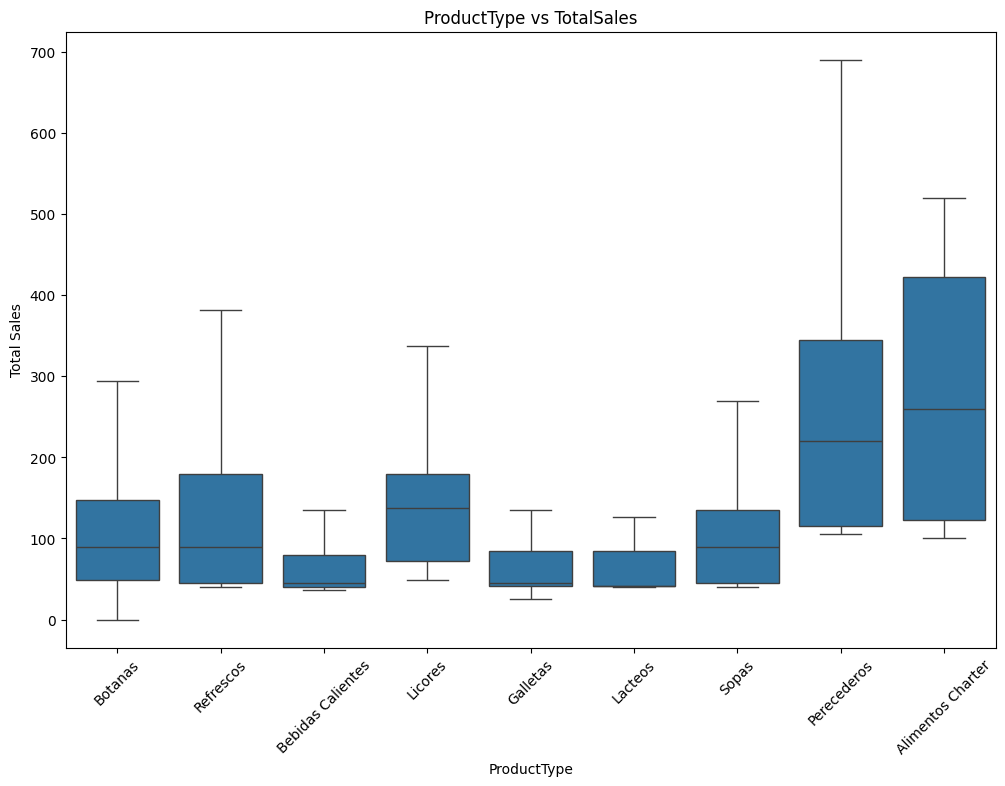

In [15]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='ProductType', y='TotalSales', data=merged_data_2023, showfliers=False)  # Showing outliers
plt.title('ProductType vs TotalSales')
plt.xlabel('ProductType')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

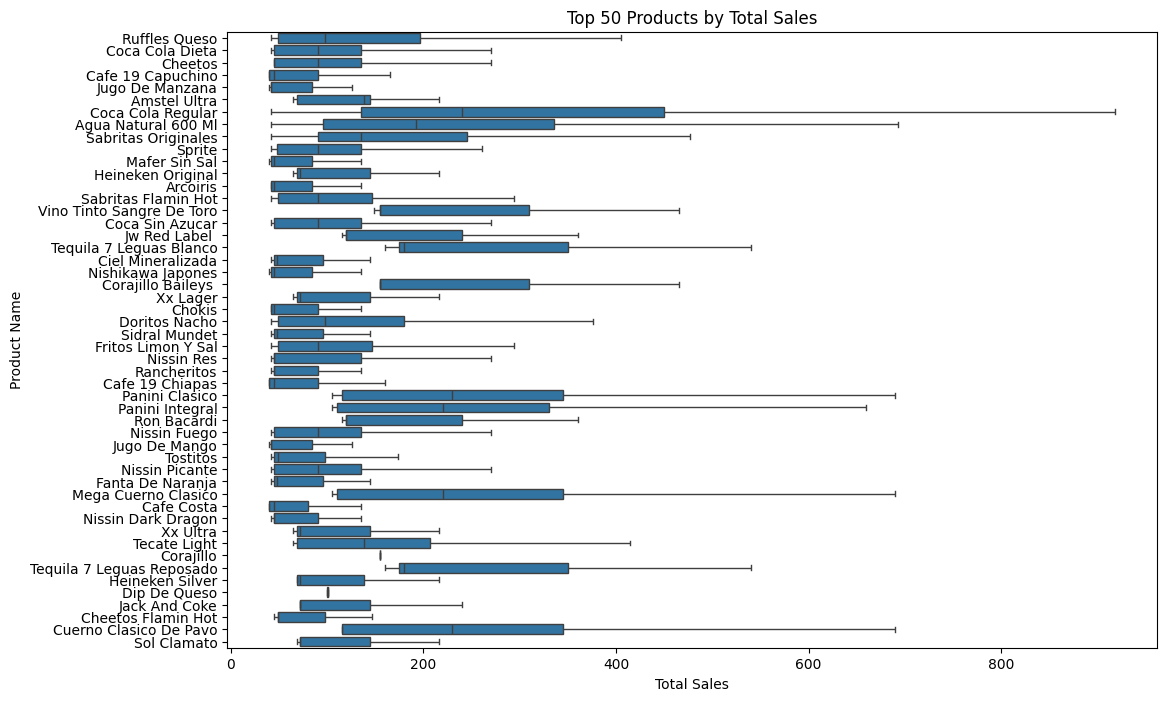

In [16]:
# Calculate total sales for each product
product_sales = merged_data_2023.groupby('ProductName')['TotalSales'].sum().reset_index()

# Select the top 10 products
top_10_products = product_sales.nlargest(50, 'TotalSales')['ProductName']

# Filter the original data for the top 10 products
merged_data_2023_top_10 = merged_data_2023[merged_data_2023['ProductName'].isin(top_10_products)]

# Relationship between ProductName and TotalSales for top 10 products (horizontal)
plt.figure(figsize=(12, 8))
sns.boxplot(x='TotalSales', y='ProductName', data=merged_data_2023_top_10, showfliers=False)  # No outliers
plt.title('Top 50 Products by Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Product Name')
plt.show()


# Model training

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, log_loss
from sklearn.preprocessing import OneHotEncoder

In [18]:
flights_data_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8694 entries, 35 to 245666
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Flight_ID         8694 non-null   object 
 1   Destination_Type  8694 non-null   object 
 2   Origin_Type       8694 non-null   object 
 3   Capacity          8694 non-null   int64  
 4   Passengers        8694 non-null   float64
 5   Bookings          8694 non-null   float64
 6   Route_ID          8694 non-null   int64  
 7   Duration          8694 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 611.3+ KB


In [19]:
# Columns to drop
cols_to_drop = ['Flight_ID']

# Drop columns not going to be used
flights_data_2023_encoded = flights_data_2023.drop(columns=cols_to_drop)

# One-hot encode categorical variables
cat_cols = ['Origin_Type', 'Destination_Type', 'Route_ID']
# cat_cols = ['Origin_Type', 'Destination_Type', 'ProductName']
flights_data_2023_encoded = pd.get_dummies(flights_data_2023_encoded, columns=cat_cols)

# Display the first few rows of the encoded dataset
flights_data_2023_encoded.head()


,Capacity,Passengers,Bookings,Duration,Origin_Type_Ciudad Fronteriza,Origin_Type_Ciudad Principal,Origin_Type_Ecoturismo,Origin_Type_MX Amigos y Familia,Origin_Type_Playa,Destination_Type_Ciudad Fronteriza,...,Route_ID_9637,Route_ID_9640,Route_ID_9719,Route_ID_9728,Route_ID_9755,Route_ID_9762,Route_ID_9767,Route_ID_9774,Route_ID_9821,Route_ID_9867
35,186,185.0,103.0,295.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
58,186,170.0,101.0,50.0,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
72,240,212.0,120.0,195.0,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
124,220,180.0,112.0,75.0,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
131,180,176.0,132.0,85.0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
# Split the data into features (X) and target variable (y)
X = flights_data_2023_encoded.drop(columns=['Passengers'])
y = flights_data_2023_encoded['Passengers']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
X

,Capacity,Bookings,Duration,Origin_Type_Ciudad Fronteriza,Origin_Type_Ciudad Principal,Origin_Type_Ecoturismo,Origin_Type_MX Amigos y Familia,Origin_Type_Playa,Destination_Type_Ciudad Fronteriza,Destination_Type_Ciudad Principal,...,Route_ID_9637,Route_ID_9640,Route_ID_9719,Route_ID_9728,Route_ID_9755,Route_ID_9762,Route_ID_9767,Route_ID_9774,Route_ID_9821,Route_ID_9867
35,186,103.0,295.0,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
58,186,101.0,50.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
72,240,120.0,195.0,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
124,220,112.0,75.0,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
131,180,132.0,85.0,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245517,220,97.0,285.0,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
245554,240,134.0,95.0,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
245562,220,118.0,80.0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
245590,180,131.0,80.0,False,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [22]:
# # Model selection and training
# import xgboost as xgb
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint

# # Create an XGBoost Regressor object
# xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

# # Define the parameters to search with reduced ranges
# param_dist = {
#     'max_depth': [5, 7, 9],
#     'learning_rate': [0.1, 0.2],
#     'n_estimators': [1000, 1200, 1500],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# # Perform randomized hyperparameter search with reduced iterations and CV folds
# random_search = RandomizedSearchCV(estimator=xgb_reg, param_distributions=param_dist, n_iter=10, cv=2, scoring='neg_mean_squared_error', verbose=3)
# random_search.fit(X_train, y_train)

# # Get the best model and its parameters
# best_estimator = random_search.best_estimator_
# best_params = random_search.best_params_

# # Train the best model on the entire training set
# best_estimator.fit(X_train, y_train)

# import joblib
# # Define the file path for saving the model
# model_file_path = "xgboost_model_" + str(month) + ".pkl"

# # Save the trained model to a file
# joblib.dump(best_estimator, model_file_path)

# # Display a message confirming the model has been saved
# print("Model saved successfully to:", model_file_path)

# Model evaluating

In [23]:
# # Import a model from a pkl file
import joblib
best_estimator = joblib.load('xgboost_model_' + str(month) + '.pkl')

# Salvar la importancia de cada feature
# Get feature importances
feature_importances = best_estimator.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Save feature importances to a CSV file
# feature_importance_df.to_csv('feature_importances_' + str(month) + '.csv', index=False)

# Display the top features
feature_importance_df

,Feature,Importance
12,Destination_Type_Playa,0.059706
7,Origin_Type_Playa,0.059205
8,Destination_Type_Ciudad Fronteriza,0.046043
1,Bookings,0.022398
6,Origin_Type_MX Amigos y Familia,0.019930
...,...,...
438,Route_ID_4032,0.000000
436,Route_ID_4019,0.000000
433,Route_ID_3978,0.000000
432,Route_ID_3972,0.000000


In [24]:
# Generate predictions on the test data
y_pred = best_estimator.predict(X_test)

# Crear un nuevo DataFrame con las predicciones y_test y y_pred
predictions_df = pd.DataFrame({'y_test': y_test, 'Predictions': y_pred})

# Mostrar las primeras filas del DataFrame resultante
predictions_df.sample(20)

,y_test,Predictions
45271,162.0,152.932770
231132,157.0,156.150970
209582,205.0,212.666550
103305,207.0,210.042114
125939,156.0,154.662567
147532,233.0,216.281372
155856,180.0,167.938019
176714,237.0,214.704483
187034,157.0,153.458420
93500,109.0,118.438423


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calcular el error absoluto medio
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calcular la raíz del error cuadrático medio
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Calcular el coeficiente de determinación (R2)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)


Mean Absolute Error: 10.090120010639211
Mean Squared Error: 176.49925358245343
Root Mean Squared Error: 13.28530216376178
R-squared: 0.8906112633346424


In [26]:
# Predict the 2023 values
predictions = best_estimator.predict(X)
flights_data_2023['Passengers_Prediction'] = predictions

# Define the columns to add from og_flights_data
columns_to_add = ['STD', 'STA', 'ArrivalStation', 'DepartureStation']

# Perform left join on flights_data_2023 and og_flights_data
flights_data_2023_pred = flights_data_2023.merge(og_flights_data[columns_to_add + ['Flight_ID']], on='Flight_ID', how='outer')


In [27]:
# Display the merged data
flights_data_2023_pred.head()

,Flight_ID,Destination_Type,Origin_Type,Capacity,Passengers,Bookings,Route_ID,Duration,Passengers_Prediction,STD,STA,ArrivalStation,DepartureStation
0,0007cd6471e979f952d9cbaa96056d0e,Ciudad Principal,Ciudad Fronteriza,186.0,185.0,103.0,35.0,295.0,163.050751,2023-01-19 23:55:00,2023-01-20 04:50:00,AO,BM
1,000d59b788ff90e47fcbf45156169f5b,MX Amigos y Familia,Playa,186.0,170.0,101.0,58.0,50.0,159.311432,2023-01-04 20:50:00,2023-01-04 21:40:00,AJ,BH
2,00117494ce95bd1fa521f6ae3e9ead6e,Ciudad Principal,Playa,240.0,212.0,120.0,72.0,195.0,215.337128,2023-01-29 21:50:00,2023-01-30 01:05:00,AT,BH
3,00204c7cf64959d95cd89f6a671a222d,Ciudad Principal,Playa,220.0,180.0,112.0,123.0,75.0,199.957458,2023-01-12 18:50:00,2023-01-12 20:05:00,AT,AB
4,00220260a070a2f42fe3e2a01114b52d,Ciudad Principal,Ciudad Principal,180.0,176.0,132.0,128.0,85.0,176.976288,2023-01-29 16:10:00,2023-01-29 17:35:00,AT,AO


In [28]:
# Intersecting Route_IDs between flights_data_2023 and flights_data_2024
intersecting_route_ids = set(flights_data_2023_pred['Route_ID']).intersection(flights_data_2024['Route_ID'])

# Filter flights_data_2023 to keep only entries with Route_IDs that exist in flights_data_2024
flights_data_2024_pred = flights_data_2023_pred[flights_data_2023_pred['Route_ID'].isin(intersecting_route_ids)].copy()

# Display the filtered dataset
flights_data_2024_pred

# Define the file path for saving the CSV file
csv_file_path = "predictions_" + str(month) + ".csv"

# Save the DataFrame to a CSV file
# flights_data_2024_pred.to_csv(csv_file_path, index=False)

# Display a message confirming the file has been saved
print("Predictions for" + str(month) + "saved successfully to:", csv_file_path)

Predictions for1saved successfully to: predictions_1.csv


# Model training (products)

In [29]:
# Join the tables on the common column 'Flight_ID'
merged_data_2024 = pd.merge(flights_data_2023, sales_data, on='Flight_ID', how='inner')

# Columns to drop
cols_to_drop = ['Flight_ID', 'ProductType']

# Drop columns not going to be used
merged_data_2024_encoded = merged_data_2024.drop(columns=cols_to_drop)

# One-hot encode categorical variables
cat_cols = ['Origin_Type', 'Destination_Type', 'Route_ID', 'ProductName']
merged_data_2024_encoded = pd.get_dummies(merged_data_2024_encoded, columns=cat_cols)

# # Group the encoded dataset by Route_ID and ProductName and sum the values
# grouped_data_by_route_id = merged_data_2024_encoded.groupby(['Route_ID', 'ProductName']).sum()

# # Display the grouped dataset
# grouped_data_by_route_id

In [30]:
merged_data_2024_encoded

,Capacity,Passengers,Bookings,Duration,Passengers_Prediction,Quantity,TotalSales,Origin_Type_Ciudad Fronteriza,Origin_Type_Ciudad Principal,Origin_Type_Ecoturismo,...,ProductName_Tecate Light,ProductName_Tequila 7 Leguas Blanco,ProductName_Tequila 7 Leguas Reposado,ProductName_Topochico Seltzer Mango,ProductName_Tostitos,ProductName_Tostitos Nachos Con Dip,ProductName_Ultra Seltzer Frambuesa,ProductName_Vino Tinto Sangre De Toro,ProductName_Xx Lager,ProductName_Xx Ultra
0,186,170.0,101.0,50.0,159.311432,1,45.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,186,170.0,101.0,50.0,159.311432,1,45.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,186,170.0,101.0,50.0,159.311432,1,45.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,186,170.0,101.0,50.0,159.311432,1,40.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,186,170.0,101.0,50.0,159.311432,2,84.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145765,220,220.0,127.0,165.0,205.908737,3,330.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
145766,220,220.0,127.0,165.0,205.908737,1,110.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
145767,220,220.0,127.0,165.0,205.908737,1,42.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
145768,220,220.0,127.0,165.0,205.908737,4,440.0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [31]:
# Split the data into features (X) and target variable (y)
X = merged_data_2024_encoded.drop(columns=['Quantity'])
y = merged_data_2024_encoded['Quantity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [32]:
# Model selection and training
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Initialize the XGBoost regression model with verbose training
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', verbose=1)

# Train the model with verbose output
xgb_reg.fit(X_train, y_train)

import joblib
# Define the file path for saving the model
model_file_path = "xgboost_model_prod_" + str(month) + ".pkl"

# Save the trained model to a file
joblib.dump(xgb_reg, model_file_path)

# Display a message confirming the model has been saved
print("Model saved successfully to:", model_file_path)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:10:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model saved successfully to: xgboost_model_prod_1.pkl


In [33]:
# # Import a model from a pkl file
# import joblib
# xgb_reg = joblib.load('xgboost_model_' + str(month) + '.pkl')

# Salvar la importancia de cada feature
# Get feature importances
feature_importances = xgb_reg.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Save feature importances to a CSV file
feature_importance_df.to_csv('feature_importances_' + str(month) + '.csv', index=False)

# Display the top features
feature_importance_df

,Feature,Importance
731,ProductName_Coca Cola Regular,0.160140
717,ProductName_Agua Natural 600 Ml,0.156839
5,TotalSales,0.107120
787,ProductName_Tostitos Nachos Con Dip,0.046306
751,ProductName_Jw Red Label,0.045088
...,...,...
327,Route_ID_2598,0.000000
328,Route_ID_2632,0.000000
329,Route_ID_2635,0.000000
330,Route_ID_2638,0.000000


In [34]:
# Generate predictions on the test data
y_pred = xgb_reg.predict(X_test)

# Round the predicted values to one decimal place
y_pred = [round(value, 0) for value in y_pred]

# Create a new DataFrame with the rounded predictions and y_test
predictions_df = pd.DataFrame({'y_test': y_test, 'Predictions': y_pred})

# Display a sample of the DataFrame
predictions_df.sample(20)

,y_test,Predictions
94287,1,1.0
109260,2,2.0
20299,1,1.0
112778,5,5.0
101648,2,2.0
110915,1,1.0
2888,1,1.0
47702,5,5.0
13630,1,1.0
52376,10,10.0


In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calcular el error absoluto medio
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calcular la raíz del error cuadrático medio
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Calcular el coeficiente de determinación (R2)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Absolute Error: 0.003923989847019277
Mean Squared Error: 0.00996089730397201
Root Mean Squared Error: 0.09980429501765949
R-squared: 0.9984557931529715


In [36]:
# Predict the 2023 values
predictions = xgb_reg.predict(X)

predictions = [round(value, 0) for value in predictions]

merged_data_2024['Quantity_Prediction'] = predictions

# Define the columns to add from og_flights_data
columns_to_add = ['STD', 'STA', 'ArrivalStation', 'DepartureStation']

# Perform left join on flights_data_2023 and og_flights_data
merged_data_2024_pred = merged_data_2024.merge(og_flights_data[columns_to_add + ['Flight_ID']], on='Flight_ID', how='outer')


In [37]:
merged_data_2024

,Flight_ID,Destination_Type,Origin_Type,Capacity,Passengers,Bookings,Route_ID,Duration,Passengers_Prediction,ProductType,ProductName,Quantity,TotalSales,Quantity_Prediction
0,000d59b788ff90e47fcbf45156169f5b,MX Amigos y Familia,Playa,186,170.0,101.0,58,50.0,159.311432,Botanas,Ruffles Queso,1,45.0,1.0
1,000d59b788ff90e47fcbf45156169f5b,MX Amigos y Familia,Playa,186,170.0,101.0,58,50.0,159.311432,Refrescos,Coca Cola Dieta,1,45.0,1.0
2,000d59b788ff90e47fcbf45156169f5b,MX Amigos y Familia,Playa,186,170.0,101.0,58,50.0,159.311432,Botanas,Cheetos,1,45.0,1.0
3,000d59b788ff90e47fcbf45156169f5b,MX Amigos y Familia,Playa,186,170.0,101.0,58,50.0,159.311432,Bebidas Calientes,Cafe 19 Capuchino,1,40.0,1.0
4,000d59b788ff90e47fcbf45156169f5b,MX Amigos y Familia,Playa,186,170.0,101.0,58,50.0,159.311432,Refrescos,Jugo De Manzana,2,84.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145765,ffe7d312395771097e61bd7ac2a9e464,Ciudad Principal,Playa,220,220.0,127.0,295,165.0,205.908737,Perecederos,Panini Clasico,3,330.0,3.0
145766,ffe7d312395771097e61bd7ac2a9e464,Ciudad Principal,Playa,220,220.0,127.0,295,165.0,205.908737,Perecederos,Panini Integral,1,110.0,1.0
145767,ffe7d312395771097e61bd7ac2a9e464,Ciudad Principal,Playa,220,220.0,127.0,295,165.0,205.908737,Lacteos,Leche De Fresa Sc,1,42.0,1.0
145768,ffe7d312395771097e61bd7ac2a9e464,Ciudad Principal,Playa,220,220.0,127.0,295,165.0,205.908737,Perecederos,Mega Cuerno Clasico,4,440.0,4.0


In [38]:
# Intersecting Route_IDs between flights_data_2023 and flights_data_2024
intersecting_route_ids = set(merged_data_2024['Route_ID']).intersection(flights_data_2024['Route_ID'])

# Filter flights_data_2023 to keep only entries with Route_IDs that exist in flights_data_2024
merged_data_2024_pred = merged_data_2024[merged_data_2024['Route_ID'].isin(intersecting_route_ids)].copy()

# Display the filtered dataset
merged_data_2024_pred

# Define the file path for saving the CSV file
csv_file_path = "predictions_products_" + str(month) + ".csv"

# Save the DataFrame to a CSV file
merged_data_2024_pred.to_csv(csv_file_path, index=False)

# Display a message confirming the file has been saved
print("Predictions for" + str(month) + "saved successfully to:", csv_file_path)

Predictions for1saved successfully to: predictions_products_1.csv


In [49]:
# Group the encoded dataset by Route_ID and ProductName and sum the values
grouped_data_by_route_id = merged_data_2024_pred.groupby(['Route_ID', 'ProductName']).sum()

# Display the grouped dataset
grouped_data_by_route_id

Flight_ID  \
Route_ID ProductName                                                                    
14       Agua Natural 600 Ml        199101b5d393c3088801259fa924f890395010f925fc54...   
         Arcoiris                   204ce04873461a5a4763f3591091169782bbf83b72448a...   
         Cafe 19 Capuchino          204ce04873461a5a4763f3591091169782bbf83b72448a...   
         Cafe 19 Chiapas                             0a10d7d7fc4c89057a8dca3a200af173   
         Cheetos                                     a482891ce7ddae3a36d994a0be9e212f   
...                                                                               ...   
6477     Nissin Picante                              e12014e73dfbc05d381926b0c7d81dae   
         Quaker Granola                              e12014e73dfbc05d381926b0c7d81dae   
         Ruffles Queso                               e12014e73dfbc05d381926b0c7d81dae   
         Sabritas Originales                         e12014e73dfbc05d381926b0c7d81dae   
         Vino Tinto Sangre De Toro                   e12014e73dfbc05d381926b0c7d81dae   

                                                                     Destination_Type  \
Route_ID ProductName                                                                    
14       Agua Natural 600 Ml        Ciudad PrincipalCiudad PrincipalCiudad Princip...   
         Arcoiris                                    Ciudad PrincipalCiudad Principal   
         Cafe 19 Capuchino           Ciudad PrincipalCiudad PrincipalCiudad Principal   
         Cafe 19 Chiapas                                             Ciudad Principal   
         Cheetos                                                     Ciudad Principal   
...                                                                               ...   
6477     Nissin Picante                                              Ciudad Principal   
         Quaker Granola                                              Ciudad Principal   
         Ruffles Queso                                               Ciudad Principal   
         Sabritas Originales                                         Ciudad Principal   
         Vino Tinto Sangre De Toro                                   Ciudad Principal   

                                                                          Origin_Type  \
Route_ID ProductName                                                                    
14       Agua Natural 600 Ml        MX Amigos y FamiliaMX Amigos y FamiliaMX Amigo...   
         Arcoiris                              MX Amigos y FamiliaMX Amigos y Familia   
         Cafe 19 Capuchino          MX Amigos y FamiliaMX Amigos y FamiliaMX Amigo...   
         Cafe 19 Chiapas                                          MX Amigos y Familia   
         Cheetos                                                  MX Amigos y Familia   
...                                                                               ...   
6477     Nissin Picante                                                    Ecoturismo   
         Quaker Granola                                                    Ecoturismo   
         Ruffles Queso                                                     Ecoturismo   
         Sabritas Originales                                               Ecoturismo   
         Vino Tinto Sangre De Toro                                         Ecoturismo   

                                    Capacity  Passengers  Bookings  Duration  \
Route_ID ProductName                                                           
14       Agua Natural 600 Ml            2028      1723.0    1127.0     880.0   
         Arcoiris                        372       294.0     205.0     160.0   
         Cafe 19 Capuchino               552       474.0     329.0     240.0   
         Cafe 19 Chiapas                 180       148.0     109.0      80.0   
         Cheetos                         186       135.0      88.0      80.0   
...                                      .